In [389]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

In [428]:
#!pip install pyshearlab 
import pyshearlab

In [6]:
#Utility functions from pyShearLab developpers
def tic():
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

# Basics

## Reading data

In [429]:
#!pip install odl
import odl

In [9]:
space = odl.uniform_discr([-1, -1], [1, 1], [512,512])

In [386]:
phantom = odl.phantom.shepp_logan(space, True)
data = np.array(phantom)

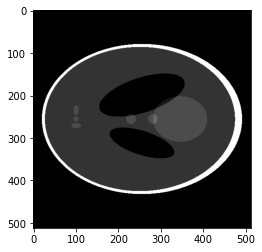

In [375]:
plt.imshow(data, cmap=plt.cm.gray)

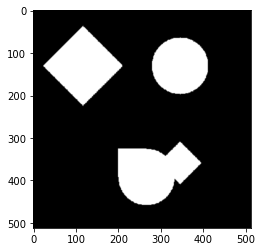

In [379]:
#Alternative image
import cv2
data2 = plt.imread("geom.png")
data2 = cv2.resize(data2.astype(float), (512, 512))[:, :, 0]
data2 = cv2.normalize(data2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(data2, cmap=plt.cm.gray)
plt.show()

## Shearlet system

In [459]:
X = data
sizeX = data.shape[0]
sizeY = data.shape[1]
rows = sizeX
cols = sizeY
useGPU = 0
nScales = 2

In [453]:
tic()
shearletSystem = pyshearlab.SLgetShearletSystem2D(useGPU, rows, cols, nScales)
toc()

Elapsed time is 3.2867939472198486 seconds.


In [189]:
shearletSystem.keys()

dict_keys(['shearlets', 'size', 'shearLevels', 'full', 'nShearlets', 'shearletIdxs', 'dualFrameWeights', 'RMS', 'useGPU', 'isComplex'])

In [222]:
shearletSystem['nShearlets']

17

In [454]:
shearletSystem['shearletIdxs'] #[cone scale shearing]

array([[ 1,  1, -2],
       [ 1,  1, -1],
       [ 1,  1,  0],
       [ 1,  1,  1],
       [ 1,  1,  2],
       [ 1,  2, -2],
       [ 1,  2, -1],
       [ 1,  2,  0],
       [ 1,  2,  1],
       [ 1,  2,  2],
       [ 2,  1, -1],
       [ 2,  1,  0],
       [ 2,  1,  1],
       [ 2,  2, -1],
       [ 2,  2,  0],
       [ 2,  2,  1],
       [ 0,  0,  0]])

In [455]:
Idxs = shearletSystem['shearletIdxs']
IdxsViz = Idxs[np.abs(Idxs[:, 2]) < 2]
iiViz  = np.argwhere(np.abs(Idxs[:, 2]) < 2).flatten()
IdxsCone1 = IdxsViz[IdxsViz[:, 0] == 1]
iiCone1 = iiViz[np.argwhere(IdxsViz[:, 0] == 1).flatten()]
IdxsCone2 = IdxsViz[IdxsViz[:, 0] == 2]
iiCone2 = iiViz[np.argwhere(IdxsViz[:, 0] == 2).flatten()]
IdxLowFreq = IdxsViz[IdxsViz[:, 0] == 0]
iiLowFreq = -1

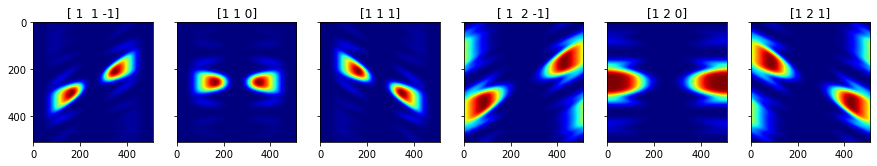

In [456]:
#Horizontal cone shearlets for different scales and shearing = -1, 0 and 1
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15, 20), sharex=True, sharey=True)
for i in range(len(IdxsCone1)) :
    ax[i].imshow(shearletSystem['shearlets'].real[:, :, iiCone1[i]], cmap='jet')
    ax[i].set_title(IdxsCone1[i])

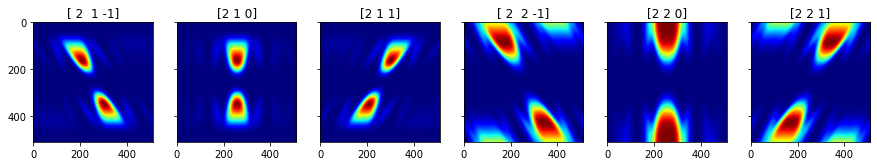

In [457]:
#Vertical cone shearlets for different scales and shearing = -1, 0 and 1
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15, 20), sharex=True, sharey=True)
for i in range(len(IdxsCone2)) :
    ax[i].imshow(shearletSystem['shearlets'].real[:, :, iiCone2[i]], cmap='jet')
    ax[i].set_title(IdxsCone2[i])


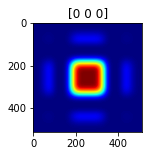

In [343]:
#Low pass region shearlet
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))
ax.imshow(shearletSystem['shearlets'].real[:, :, -1], cmap='jet')
ax.set(title=Idxs[-1], xticks=[0, 200, 400], yticks=[0, 200, 400])
plt.show()

## Shearlet Decomposition

In [382]:
tic()
coeffs = pyshearlab.SLsheardec2D(X, shearletSystem)
toc()

Elapsed time is 0.5706045627593994 seconds.


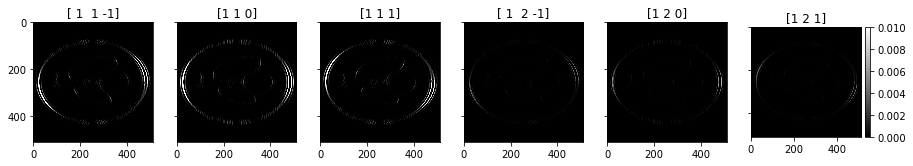

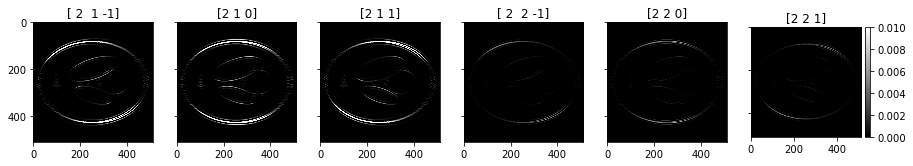

In [383]:
#Shearlet coefficients and sum of all coefficientsS
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15, 20), sharex=True, sharey=True)
for i in range(len(IdxsCone1)) :
    im = ax[i].imshow(coeffs[:,:,iiCone1[i]], vmin=0, vmax=0.01, cmap=plt.cm.gray)
    ax[i].set_title(IdxsCone1[i])
    
divider = make_axes_locatable(ax[i])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15, 20), sharex=True, sharey=True)
for i in range(len(IdxsCone2)) :
    ax[i].imshow(coeffs[:,:, iiCone2[i]], vmin=0, vmax=0.01, cmap=plt.cm.gray)
    ax[i].set_title(IdxsCone2[i])

divider = make_axes_locatable(ax[i])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()


## Shearlet Reconstruction

In [384]:
tic()
Xrec = pyshearlab.SLshearrec2D(coeffs, shearletSystem)
toc()

Elapsed time is 0.4238924980163574 seconds.


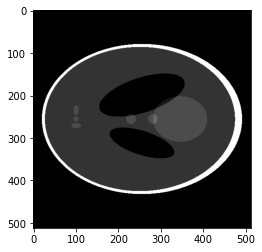

In [385]:
plt.imshow(Xrec, cmap=plt.cm.gray)
plt.show()

# Applications

## Image Denoising

In [421]:
import skimage

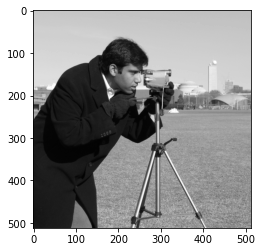

In [620]:
X = skimage.data.camera()
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

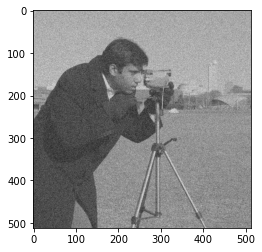

In [621]:
sigma = 30
Xnois = X + sigma*np.random.randn(X.shape[0], X.shape[1])
plt.imshow(Xnois, cmap=plt.cm.gray)
plt.show()

In [622]:
# Generate shearlet system with 4 scales (e.g.)
scales = 4
tic()
shearletSystem = pyshearlab.SLgetShearletSystem2D(0, X.shape[0], X.shape[1], scales)
toc()

Elapsed time is 21.738308429718018 seconds.


In [623]:
# Decomposition
tic()
coeffs = pyshearlab.SLsheardec2D(Xnois, shearletSystem)
toc()

Elapsed time is 1.1540274620056152 seconds.


In [624]:
# Thresholding
thresholdingFactor = 3
weights = np.ones(coeffs.shape)

for j in range(len(shearletSystem["RMS"])):
    weights[:,:,j] = shearletSystem["RMS"][j]*np.ones((X.shape[0], X.shape[1]))
    
thresh_coeffs = np.real(coeffs)
zero_indices = np.abs(coeffs) / (thresholdingFactor * weights * sigma) < 1
thresh_coeffs[zero_indices] = 0

In [625]:
# Reconstruction
tic()
Xrec = pyshearlab.SLshearrec2D(thresh_coeffs, shearletSystem)
toc()

Elapsed time is 0.8578982353210449 seconds.


PSNR: 28.4515956009


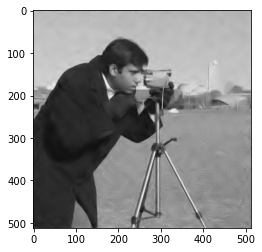

In [626]:
PSNR = pyshearlab.SLcomputePSNR(X, Xrec)
print("PSNR: " + str(PSNR))
plt.imshow(Xrec, cmap=plt.cm.gray)
plt.show()

## Inpainting

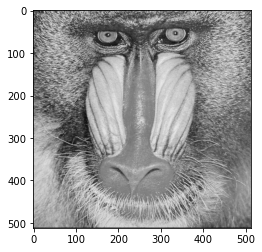

(512, 512)

In [628]:
X = plt.imread("monkey.png")
plt.imshow(X, cmap=plt.cm.gray)
plt.show()
X.shape

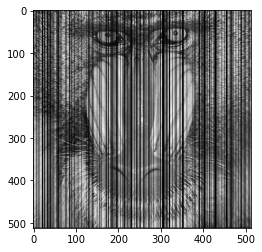

In [662]:
mask = np.random.uniform(0, 1, size=(512)) > 0.3
Xmasked = X * mask
plt.imshow(Xmasked, cmap=plt.cm.gray)

In [568]:
def inpaint2D(XMasked, mask, nIter,stopFactor,shearletSystem):
    # Compute coefficients
    coeffs = pyshearlab.SLsheardec2D(XMasked, shearletSystem)
    # Normalize the coefficients
    coeffsNormalized = np.zeros(coeffs.shape, np.complex64)     
    for i in range(shearletSystem['nShearlets']):
        coeffsNormalized[:,:,i] = coeffs[:,:,i] / shearletSystem['RMS'][i]
    # Define the parameters
    delta = np.abs(coeffsNormalized).max()
    lbda = (stopFactor)**(1/(nIter-1))
    XInpainted = np.zeros(XMasked.shape)
    #Iterative thresholding
    for it in range(nIter):
        res = mask * (XMasked - XInpainted);
        coeffs = pyshearlab.SLsheardec2D(XInpainted+res, shearletSystem);
        coeffsNormalized = np.zeros(coeffs.shape, np.complex64);
        for i in range(shearletSystem['nShearlets']):
            coeffsNormalized[:,:,i] = coeffs[:,:,i]/shearletSystem['RMS'][i]
        coeffs = coeffs * (np.abs(coeffsNormalized) > delta)
        XInpainted = pyshearlab.SLshearrec2D(coeffs, shearletSystem)
        delta = delta * lbda 
        print('Iteration ', it, ' of ', nIter)
    return XInpainted

In [705]:
scales = 4
shearletSystem = pyshearlab.SLgetShearletSystem2D(0, X.shape[0], X.shape[1], scales)

In [569]:
nIter = 150
stopFactor = 0.005
tic()
inpainted_mask_uniform = inpaint2D(Xmasked, mask, nIter, stopFactor, shearletSystem)
toc()

Iteration  0  of  150
Iteration  1  of  150
Iteration  2  of  150
Iteration  3  of  150
Iteration  4  of  150
Iteration  5  of  150
Iteration  6  of  150
Iteration  7  of  150
Iteration  8  of  150
Iteration  9  of  150
Iteration  10  of  150
Iteration  11  of  150
Iteration  12  of  150
Iteration  13  of  150
Iteration  14  of  150
Iteration  15  of  150
Iteration  16  of  150
Iteration  17  of  150
Iteration  18  of  150
Iteration  19  of  150
Iteration  20  of  150
Iteration  21  of  150
Iteration  22  of  150
Iteration  23  of  150
Iteration  24  of  150
Iteration  25  of  150
Iteration  26  of  150
Iteration  27  of  150
Iteration  28  of  150
Iteration  29  of  150
Iteration  30  of  150
Iteration  31  of  150
Iteration  32  of  150
Iteration  33  of  150
Iteration  34  of  150
Iteration  35  of  150
Iteration  36  of  150
Iteration  37  of  150
Iteration  38  of  150
Iteration  39  of  150
Iteration  40  of  150
Iteration  41  of  150
Iteration  42  of  150
Iteration  43  of  15

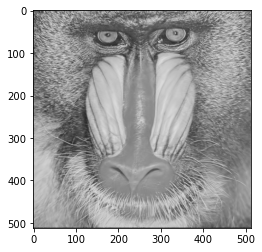

PSNR: 75.0564984692


In [574]:
plt.imshow(inpainted_mask_uniform, cmap=plt.cm.gray)
plt.show()
PSNR = pyshearlab.SLcomputePSNR(X, inpainted_mask_uniform)
print("PSNR: " + str(PSNR))

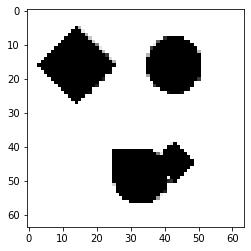

In [717]:
M = plt.imread("geom.png")
M = cv2.resize(M.astype(float), (64, 64))[:, :, 0]
M = cv2.normalize(M, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
where_0 = np.where(M== 0)
where_1 = np.where(M == 1)
M[where_0] = 1
M[where_1] = 0
plt.imshow(M, cmap=plt.cm.gray)

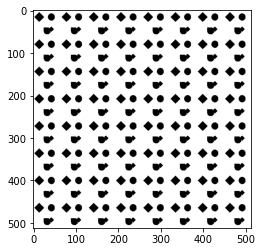

In [719]:
M = np.hstack([M]*8)
M = np.vstack([M]*8)
plt.imshow(M, cmap=plt.cm.gray)
plt.show()

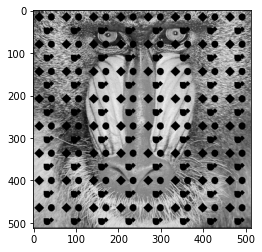

In [707]:
Xmask_geom = X * M
plt.imshow(Xmask_geom, cmap=plt.cm.gray)
plt.show()

In [710]:
nIter = 150
stopFactor = 0.005
tic()
inpainted_mask_geom = inpaint2D(Xmask_geom, M, nIter, stopFactor, shearletSystem)
toc()

Iteration  0  of  150
Iteration  1  of  150
Iteration  2  of  150
Iteration  3  of  150
Iteration  4  of  150
Iteration  5  of  150
Iteration  6  of  150
Iteration  7  of  150
Iteration  8  of  150
Iteration  9  of  150
Iteration  10  of  150
Iteration  11  of  150
Iteration  12  of  150
Iteration  13  of  150
Iteration  14  of  150
Iteration  15  of  150
Iteration  16  of  150
Iteration  17  of  150
Iteration  18  of  150
Iteration  19  of  150
Iteration  20  of  150
Iteration  21  of  150
Iteration  22  of  150
Iteration  23  of  150
Iteration  24  of  150
Iteration  25  of  150
Iteration  26  of  150
Iteration  27  of  150
Iteration  28  of  150
Iteration  29  of  150
Iteration  30  of  150
Iteration  31  of  150
Iteration  32  of  150
Iteration  33  of  150
Iteration  34  of  150
Iteration  35  of  150
Iteration  36  of  150
Iteration  37  of  150
Iteration  38  of  150
Iteration  39  of  150
Iteration  40  of  150
Iteration  41  of  150
Iteration  42  of  150
Iteration  43  of  15

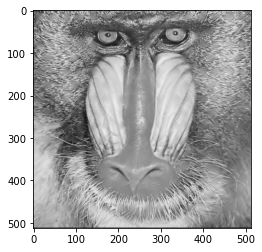

PSNR: 73.5681202443


In [718]:
plt.imshow(inpainted_mask_geom, cmap=plt.cm.gray)
plt.show()
PSNR = pyshearlab.SLcomputePSNR(X, inpainted_mask_geom)
print("PSNR: " + str(PSNR))